* The model, The loss function, a minibatch stochastic gradient optimizer, the training function that stiches all these pieces together.

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

### Defining the model

* Before optimizing, we need to have some params in the first place.
* We initialize weights by drawing random numbers from normal distribution with mean 0 and SD 0.01(specify a different value through the arg *sigma*).

In [2]:
class LinearRegressionScratch(d2l.Module):
    def __init__(self, ip_num, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameter()
        self.w = torch.normal(0, sigma, (ip_num, 1 ), requires_grad = True)
        self.b = torch.zeros(1, requires_grad=True)


In [3]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, x):
    return torch.matmul(x, self.w) + self.b

### Defining the Loss Function

In [4]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = (y_hat-y) ** 2 / 2
    return l.mean()

### Defining the Optimization algorithm

In [5]:
class SGD(d2l.HyperParameters):
    def __init__(self, params, lr):
        self.save_hyperparameter()
    
    def step(self):
        for param in self.params:
            param -= self.lr * param.grad
    
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [6]:
@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

### Training

* In each iteration, we grad a minibatch of training examples, and compute its loss through the model's training_step method.
* Then we compute the gradients w.r.t each parameter.
* Finally, we will call the optimization algorithm to update the model parameters.
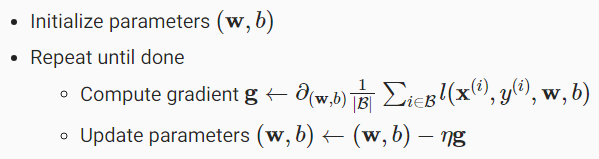

In [7]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

In [ ]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)